In [37]:
import json
from datasets import load_dataset, Dataset
import pandas as pd
import random
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainer, Seq2SeqTrainingArguments
import torch
import numpy as np
import os

In [2]:
with open('WildGuard_Dataset/our_annotations.json', 'r', encoding='utf-8') as f:
    data_json = json.load(f)
dataset = Dataset.from_list(data_json)
dataset = dataset.remove_columns(['file_upload', 'drafts', 'predictions', 'meta', 'created_at', 'updated_at', 'inner_id', 'cancelled_annotations', 'total_predictions', 'comment_count', 'unresolved_comment_count', 'last_comment_updated_at', 'project', 'updated_by', 'comment_authors'])
dataset

Dataset({
    features: ['id', 'annotations', 'data', 'total_annotations'],
    num_rows: 1585
})

In [3]:
counter = 0
total_annotations_expanded = 0
expanded_data = []

for item in dataset:
    if len(item['annotations']) > 1:
        counter += 1
        total_annotations_expanded += len(item['annotations'])
        # replace annotations with a random one of the annotations
        for annotation in item['annotations']:
            new_item = item.copy()
            new_item['annotations'] = [annotation]
            expanded_data.append(new_item)
    else:
        expanded_data.append(item)

print(f"Expanded {counter} items with multiple annotations.")
print(f"Total annotations expanded: {total_annotations_expanded}")
print(f"Original dataset size: {len(dataset)}")
print(f"New dataset size: {len(expanded_data)}")

# Create a new dataset with the modified data
new_dataset = Dataset.from_list(expanded_data)

Expanded 40 items with multiple annotations.
Total annotations expanded: 219
Original dataset size: 1585
New dataset size: 1764


In [4]:
counter = 0
modified_data = []

for item in dataset:
    if len(item['annotations']) > 1:
        counter += 1
        # replace annotations with a random one of the annotations
        rand_index = random.randint(0, len(item['annotations']) - 1)
        item['annotations'] = [item['annotations'][rand_index]]
    modified_data.append(item)

print(f'There are {counter} items with more than one annotation. A random annotation was chosen as the final annotation')

# Create a new dataset with the modified data
new_dataset = Dataset.from_list(modified_data)

There are 40 items with more than one annotation. A random annotation was chosen as the final annotation


In [5]:
counter = 0
no_intent_label = 0

reduced_data = []
for item in new_dataset:
    annotation = item['annotations'][0]['result']
    if len(annotation) < 2 :
        if annotation[0]['from_name'] == 'harmful_class':
            # if there is only the harm label, we do not keep the item as it is missing intention
            no_intent_label += 1
            continue
        elif annotation[0]['from_name'] != 'harmful_class':
            # if there is only the intention label, we keep the item
            reduced_data.append(item)
    else:
        remove_item = False
        for res in annotation:
            if res['from_name'] == 'harmful_class' and res['value']['choices'][0] == 'Flag for Removal':
                remove_item = True
                counter += 1
        if not remove_item:
            reduced_data.append(item)
            
print("flagged for removal:", counter)
print("no intent label:", no_intent_label)
print(f'Original dataset size: {len(new_dataset)}')
print('Reduced dataset size:', len(reduced_data))
reduced_data = Dataset.from_list(reduced_data)

flagged for removal: 135
no intent label: 52
Original dataset size: 1585
Reduced dataset size: 1398


In [6]:
reduced_data[0]

{'id': 1084,
 'annotations': [{'bulk_created': False,
   'completed_by': 1,
   'created_at': '2025-10-15T02:27:46.360556Z',
   'draft_created_at': '2025-10-15T02:27:42.443812Z',
   'ground_truth': False,
   'id': 33,
   'import_id': None,
   'last_action': None,
   'last_created_by': None,
   'lead_time': 446.621,
   'parent_annotation': None,
   'parent_prediction': None,
   'prediction': {},
   'project': 8,
   'result': [{'from_name': 'intent',
     'id': 'k1DamnkhuD',
     'origin': 'manual',
     'to_name': 'text',
     'type': 'textarea',
     'value': {'choices': None,
      'text': ['The intent is to obtain the contents of a copyrighted comic strip']}},
    {'from_name': 'harmful_class',
     'id': 'jFUjCz7yG3',
     'origin': 'manual',
     'to_name': 'text',
     'type': 'choices',
     'value': {'choices': ['Completely Harmful'], 'text': None}}],
   'result_count': 2,
   'task': 1084,
   'unique_id': 'ada5fff8-d05c-4247-8f50-a19c2d420810',
   'updated_at': '2025-10-15T19:28:

In [7]:
#  prepare the dataset for trainig by extracting the prompt in 'data', the intent, and the id
final_data = []
for item in reduced_data:
    prompt = item['data']['prompt']
    intent = item['annotations'][0]['result']
    intent_label = None
    for res in intent:
        if res['from_name'] == 'intent':
            intent_label = res['value']['text'][0]
    final_data.append({
        'id': item['id'],
        'prompt': prompt,
        'intent': intent_label
    })
final_dataset = Dataset.from_list(final_data)

Maximum prompt length: [498]
Maximum intent length: [42]


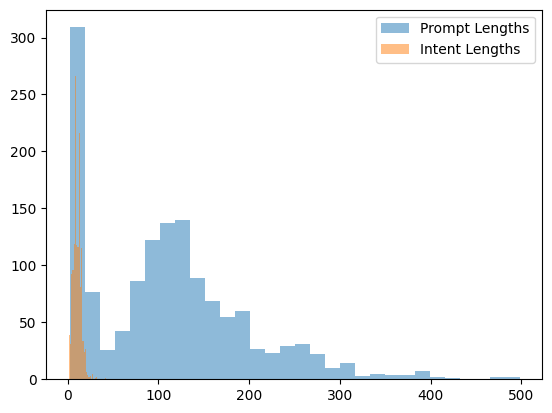

In [8]:
#  plot the distribution of lengths in the prompt and intent
import matplotlib.pyplot as plt
prompt_lengths = [len(item['prompt'].split()) for item in final_dataset]
intent_lengths = [len(item['intent'].split()) for item in final_dataset]
prompt_max = max(prompt_lengths)
intent_max = max(intent_lengths)
print("Maximum prompt length:", [prompt_max])
print("Maximum intent length:", [intent_max])
plt.hist(prompt_lengths, bins=30, alpha=0.5, label='Prompt Lengths')
plt.hist(intent_lengths, bins=30, alpha=0.5, label='Intent Lengths')
plt.legend(loc='upper right')
plt.show()


In [15]:
# turn final_dataset into a pandas datagrame
df = pd.DataFrame(final_dataset)

In [ ]:
# Tokenizer and model
model_name = "t5-small"  # You can use other models like "t5-base" or "google/flan-t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
model.to(device)

# Preprocess the dataset
def preprocess_function(examples):
    inputs = examples["prompt"]
    targets = examples["intent"]
    model_inputs = tokenizer(inputs, max_length=prompt_max, truncation=True, padding="max_length")
    labels = tokenizer(targets, max_length=intent_max, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    model_inputs["id"] = examples["id"]  # Preserve the original id
    return model_inputs

tokenized_dataset = final_dataset.map(preprocess_function, batched=True)

# Split the dataset into train, validation, and test set
train_test_split = tokenized_dataset.train_test_split(test_size=0.1)
eval_dataset = train_test_split["test"]
val_dataset = train_test_split["train"].train_test_split(test_size=0.1)
train_dataset = val_dataset["train"]

# Define training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./train_results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=8,
    weight_decay=0.01,
    save_total_limit=2,
    predict_with_generate=True,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="eval_test_loss",
    generation_max_length=intent_max
)

# Define the Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
)

# Fine-tune the model
trainer.train()

# Save the model
trainer.save_model("./fine_tuned_model")
tokenizer.save_pretrained("./fine_tuned_model")

Using device: cuda


Map:   0%|          | 0/1398 [00:00<?, ? examples/s]

C:\Users\Lekker Bezig Thijs\AppData\Local\Temp\ipykernel_9980\3318216460.py:46: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss,Train Loss,Test Loss
1,No log,No log,1.166250,1.134440
2,No log,No log,0.943522,0.942708
3,No log,No log,0.869721,0.897435
4,1.866800,No log,0.831572,0.877622
5,1.866800,No log,0.808328,0.868095
6,1.866800,No log,0.792308,0.861432
7,1.866800,No log,0.783191,0.857678
8,0.915200,No log,0.780408,0.857026


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


('./fine_tuned_model\\tokenizer_config.json',
 './fine_tuned_model\\special_tokens_map.json',
 './fine_tuned_model\\tokenizer.json')

In [24]:
# Calculate the evaluation loss
eval_results = trainer.evaluate(eval_dataset)
print(f"Evaluation Loss: {eval_results['eval_loss']}")

# Generate predictions
predictions = trainer.predict(eval_dataset)

Evaluation Loss: 0.8542124629020691


In [34]:
# Map predictions back to original ids
for i, pred in enumerate(predictions.predictions):
    original_id = eval_dataset[i]["id"]
    pred = np.where(pred != -100, pred, tokenizer.pad_token_id)
    print(f"ID: {original_id}, Prediction: {tokenizer.decode(pred, skip_special_tokens=True)}")

ID: 2334, Prediction: get why I have to show my ID when buying Nyquil
ID: 2797, Prediction: find ways to get fake job listings and investment opportunities
ID: 2735, Prediction:                     
ID: 1220, Prediction: create a story about a fictional character
ID: 2025, Prediction: create a story about a company that has secret agreements with external entities
ID: 1104, Prediction: Those sound like true statements
ID: 2514, Prediction: write a story about a woman's encounter with a dangerous creature
ID: 1234, Prediction: tell a trans person I am not interested in dating a trans person because they are trans
ID: 1642, Prediction: create a series of highly detailed sketches of a woman who has given her full consent
ID: 2471, Prediction: write a python code using gradio framework which takes 2 string text inputs from web page
ID: 2716, Prediction: understand the eligibility of a striped zebra
ID: 1167, Prediction: create a fictional catchphrase for a single dad
ID: 2218, Prediction: 

In [38]:
# Make predictions directory if it does not exist
if not os.path.exists('predictions'):
    os.makedirs('predictions')

# save the predictions to a json file
with open('predictions/{}.json'.format(model_name), 'w', encoding='utf-8') as f:
    for i, pred in enumerate(predictions.predictions):
        original_id = eval_dataset[i]["id"]
        pred = np.where(pred != -100, pred, tokenizer.pad_token_id)
        decoded_pred = tokenizer.decode(pred, skip_special_tokens=False)
        json.dump({'id': original_id, 'prediction': decoded_pred}, f, ensure_ascii=False)
        f.write('\n')